## Приложение для онлайн-знакомств

Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

## 1. Предобработка и предварительный анализ

* импортируем необходимые для анализа библиотеки:

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as ss
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

* подгрузим данные и произведем "первичный" осмотр:

In [2]:
df = pd.read_csv('dating_data.csv')

In [3]:
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [5]:
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

In [6]:
df.group.value_counts()

group
1    9722
0    4792
Name: count, dtype: int64

group:
* 0 - контрольная группа (пользовались приложением со старым алгоритмом);
* 1 - экспертиментальная группа (пользовались новым алгоритмом для поиска анкет).

*Уникальных пользователей user_id_1 и user_id_2 одинаковое количество. Количество записей в экспериментальной группе больше, чем в контрольной почти в 2 раза. Но user_id_1 и user_id_2 это картина взаимодействия между пользователями. Для более правильной и адекватной оценки нужна картина по каждому пользователю. Нужно произвести агрегацию по каждому пользователю рассчитав кол-во его действий (лайков и дизлайков) и кол-во мэтчей. Дальше посмотрим на уникальное кол-во пользователей в каждой из групп.*

* Для лучшего понимания картины посмотрим на пример данных для пользователя под id 716:

In [7]:
df.query('user_id_1 == 716')

,user_id_1,user_id_2,group,is_match
1,716,353,1,1
830,716,485,1,1
2340,716,323,1,0
3841,716,495,1,0
4344,716,286,1,0
4916,716,48,1,0
6163,716,115,1,1
6228,716,351,1,0
6614,716,24,1,1
7086,716,584,1,0


In [8]:
df.query('user_id_2 == 716')

,user_id_1,user_id_2,group,is_match
320,724,716,1,0
682,617,716,1,1
1021,289,716,1,0
2091,804,716,1,0
2402,512,716,1,0
3158,272,716,1,0
3673,514,716,1,0
3843,404,716,1,0
4169,310,716,1,1
4348,139,716,1,0


*Получается, что один пользователь может как лайкать/дизлайкать разных пользователей, так и быть "выбранным" (его тоже могут лайкать/дизлайкать). Предполагаю, что достаточно сгруппировать данные по user_id_1, то есть учитывать односторонний выбор, т.к. двусторонний выбор исказит наши данные, потому что один пользователь будет учтен дважды.*
* Также важно проверить пересекаются ли наши группы:

In [9]:
len(
    set(df.query('group == 0').user_id_1).intersection(
    set(df.query('group == 1').user_id_1))
   )

0

In [10]:
len(
    set(df.query('group == 0').user_id_2).intersection(
    set(df.query('group == 1').user_id_2))
   )

0

In [11]:
len(
    set(df.query('group == 0').user_id_1).intersection(
    set(df.query('group == 1').user_id_2))
   )

0

In [12]:
len(
    set(df.query('group == 0').user_id_1).intersection(
    set(df.query('group == 0').user_id_2))
   )

501

In [13]:
len(
    set(df.query('group == 1').user_id_1).intersection(
    set(df.query('group == 1').user_id_2))
   )

499

<b>Получается, пользователи между группами не пересекаются. Отсюда вывод: <u><font color='green'>наши выборки не связаны. </u></font></b>

* Произведем агрегацию данных:

In [14]:
aggregate = (
            df.groupby(['user_id_1', 'group'], as_index=False) 
              .agg({'user_id_2': 'count',  # посчитаем кол-во действий пользователя, т.е. скольким другим пользователям он поставил лайк/дизлайк 
                    'is_match': 'sum'})   # определим сумму мэтчей у пользователя, т.е. сколько у него случилось взаимных лайков
              .rename(columns={'user_id_1': 'user_id',
                               'user_id_2': 'actions',
                               'is_match': 'matchs_count'})
            )

aggregate['matchs_share'] = round(aggregate['matchs_count'] / aggregate['actions'], 2) # посчитаем долю мэтчей среди действий пользователя, это будет нашей первой метрикой
aggregate

,user_id,group,actions,matchs_count,matchs_share
0,1,1,24,11,0.46
1,2,1,16,7,0.44
2,3,1,16,5,0.31
3,4,0,9,2,0.22
4,5,1,22,13,0.59
...,...,...,...,...,...
995,996,0,8,1,0.12
996,997,0,12,1,0.08
997,998,1,18,10,0.56
998,999,0,7,2,0.29


In [15]:
aggregate.group.value_counts()

group
0    501
1    499
Name: count, dtype: int64

<b>Наши выборки практически равны по размеру.

Теперь данные готовы к анализу результатов эксперимента по внедрению нового алгоритма для поиска анкет.

Опеределим две метрики, которые будут нас интересовать и сравнение которых позволят нам сделать вывод об эффективности нового алгоритма:</b>

1. <b><font color='red'>matchs_share</font></b> - процент мэтчей среди всех лайков/дизлайков у пользователя. Если разработчики утверждают, что новый алгоритм подразумевает улучшение поиска наиболее подходящих анкет, то эта метрика должна вырасти.

2. <b><font color='red'>actions</font></b> - количество действий пользователя. Мы заинтересованы, чтобы пользователи больше времени проводили в нашем приложении, соответственно, совершали больше действий. Поэтому важно понять, с появлением нового алгоритма, стали ли пользователи совершать больше действий.

* Начнем анализировать результаты эксперимента и делать выводы с метрики matchs_share.

## 2. Сравнение доли мэтчей между контрольной и тестовой группами

* Визуализируем значения matchs_share между группами: 

<Axes: xlabel='group', ylabel='matchs_share'>

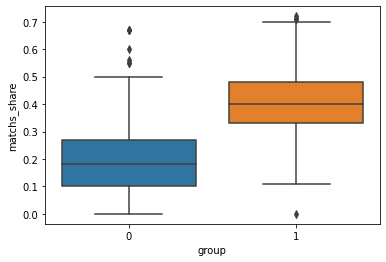

In [16]:
sns.boxplot(data=aggregate, x='group', y = 'matchs_share')

In [17]:
aggregate.query('group == 0').matchs_share.describe()

count    501.000000
mean       0.193593
std        0.134368
min        0.000000
25%        0.100000
50%        0.180000
75%        0.270000
max        0.670000
Name: matchs_share, dtype: float64

In [18]:
aggregate.query('group == 1').matchs_share.describe()

count    499.000000
mean       0.402405
std        0.114209
min        0.000000
25%        0.330000
50%        0.400000
75%        0.480000
max        0.720000
Name: matchs_share, dtype: float64

Исходя из полученных данных видно:
* разница между 25, 50 и 75 квантилями в обеих группах равномерна;
* стандартное отклонение в контрольной группе больше, чем в эспериментальной;
* максимальное значение matchs_share в экспериментальной группе немного выше, чем в контрольной;
* среднее значение matchs_share у экспериментальной группы больше, чем у контрольной практически в 2 раза.

Давайте попробуем понять насколько различия в **matchs_share** статистически значимы.

* Для начала проверим наши распределения на нормальность:

Text(0.5, 1.0, 'experiment (group = 1)')

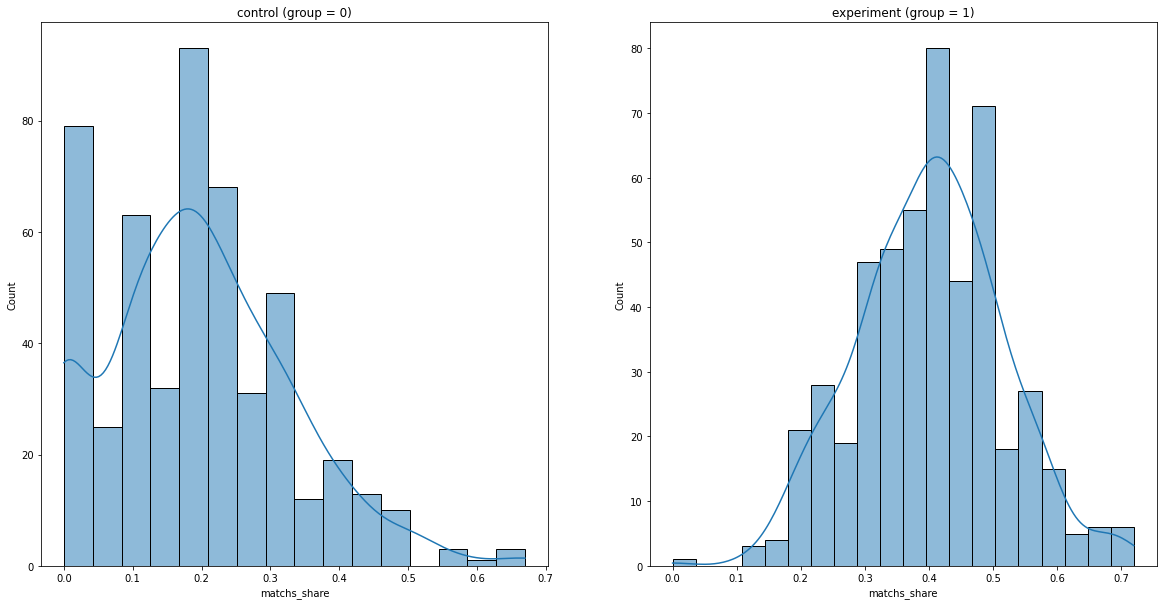

In [19]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(data=aggregate.query('group == 0'), x='matchs_share', kde=True, ax=axs[0])
axs[0].set_title('control (group = 0)')
sns.histplot(data=aggregate.query('group == 1'), x='matchs_share', kde=True, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

*Визуально, в экспериментальной группе распределение кажется нормальным. В контрольной группе распределение далеко от нормального.* 
* Проведем тест на нормальность с помощью библиотек **pingouin** и **scipy**:

Text(0.5, 1.0, 'experiment (group = 1)')

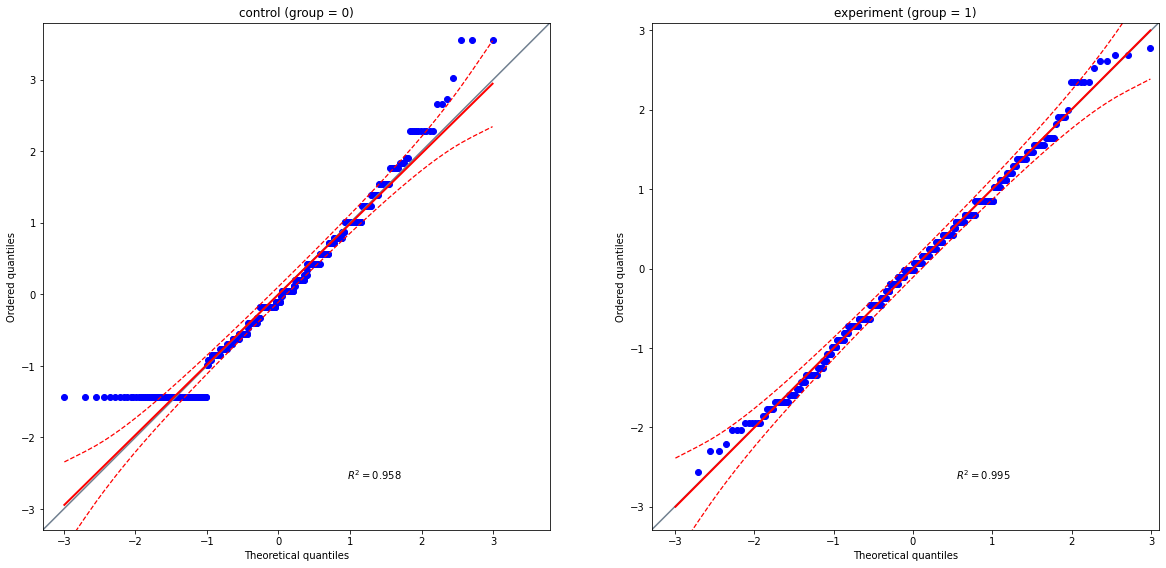

In [20]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

pg.qqplot(x=aggregate.query('group == 0').matchs_share, ax=axs[0])
axs[0].set_title('control (group = 0)')
pg.qqplot(x=aggregate.query('group == 1').matchs_share, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

In [21]:
pg.normality(data=aggregate, dv='matchs_share', group='group')

,W,pval,normal
group,,,
1,0.995512,1.621243e-01,True
0,0.956622,5.654006e-11,False


In [22]:
ss.normaltest(aggregate.query('group == 0').matchs_share)

NormaltestResult(statistic=25.012374661106712, pvalue=3.703666323992913e-06)

In [23]:
ss.normaltest(aggregate.query('group == 1').matchs_share)

NormaltestResult(statistic=0.2799194978631532, pvalue=0.8693932287008774)

<i>Исходя из вышеприведенных результатов с высокой долей уверенности можно сделать вывод, что распределение в контрольной группе не имеет нормальный вид, а данные в экспериментальной группе имеют нормальное распределение.

Итак, что мы хотим? Мы хотим понять, есть ли статистически значимые различия между двумя группами. Будем сравнивать средние значения доли мэтчей. Можем ли мы применить т-критерий Стьюдента для наших выборок, учитывая, что одна из них не имеет нормальное распределение? 

Нормальность данных критична только для очень маленьких выборок (примерный ориентир – меньше 30). У нас выборки по 500 записей в каждой, поэтому т-тест будет работать корректно. Тест должен быть параметрическим, т.к. все параметры выборки нам известны.

Плюс мы знаем, что стандартные отклонения наших выборок не равны. Поэтому для сравнения средних значений доли мэтчей между двумя группами будем использовать <u>т-критерий Уэлча</u> для наших несвязанных выборок, где:</i>
* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том что средние значения не отличаются;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о том что средние значения в выборках отличаются.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Произведем расчеты т-теста разными библиотеками: 

In [24]:
pg.ttest(aggregate.query('group == 0').matchs_share, 
         aggregate.query('group == 1').matchs_share,
         correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-26.481432,973.937119,two-sided,7.890669e-117,"[-0.22, -0.19]",1.674296,3.052e+113,1.0


In [25]:
ss.ttest_ind(aggregate.query('group == 0').matchs_share, 
             aggregate.query('group == 1').matchs_share,
             equal_var=False)

Ttest_indResult(statistic=-26.481431782585016, pvalue=7.890669157070396e-117)

**Мы получили в качестве p-value очень маленькое число - со степенью "-(минус) 117". Это говорит нам, что мы можем отвергнуть нулевую гипотезу и сделать вывод, что <font color='green'>средние между двумя группами статистически различаются.</font>** 

**Отрицательное значение переменной т-статистики говорит нам о том, что значения средней доли мэтчей в экспериментальной группе выше, чем в контрольной. То есть мы статистически подтвердили полученные выше данные.**



## 3. Сравнение среднего количества действий (лайков/дизлайков) между 2 группами

* Визуализируем значения actions между группами 

<Axes: xlabel='group', ylabel='actions'>

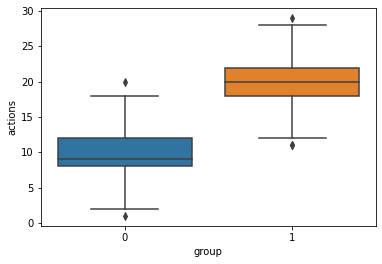

In [26]:
sns.boxplot(data=aggregate, x='group', y = 'actions')

In [27]:
aggregate.query('group == 0').actions.describe()

count    501.000000
mean       9.564870
std        3.056515
min        1.000000
25%        8.000000
50%        9.000000
75%       12.000000
max       20.000000
Name: actions, dtype: float64

In [28]:
aggregate.query('group == 1').actions.describe()

count    499.000000
mean      19.482966
std        2.991489
min       11.000000
25%       18.000000
50%       20.000000
75%       22.000000
max       29.000000
Name: actions, dtype: float64

Исходя из полученных данных видно:
* разница между 25, 50 и 75 квантилями равномерна только в экспериментальной группе;
* стандартное отклонение в обеих группах примерно одинаково;
* минимальное значение actions в экспериментальной группе гораздо выше, чем в контрольной;
* среднее значение actions у экспериментальной группы больше, чем у контрольной практически в 2 раза. 

Давайте попробуем понять насколько различия в средних значениях **actions** статистически значимы.

* Для начала проверим наши распределения на нормальность:

Text(0.5, 1.0, 'experiment (group = 1)')

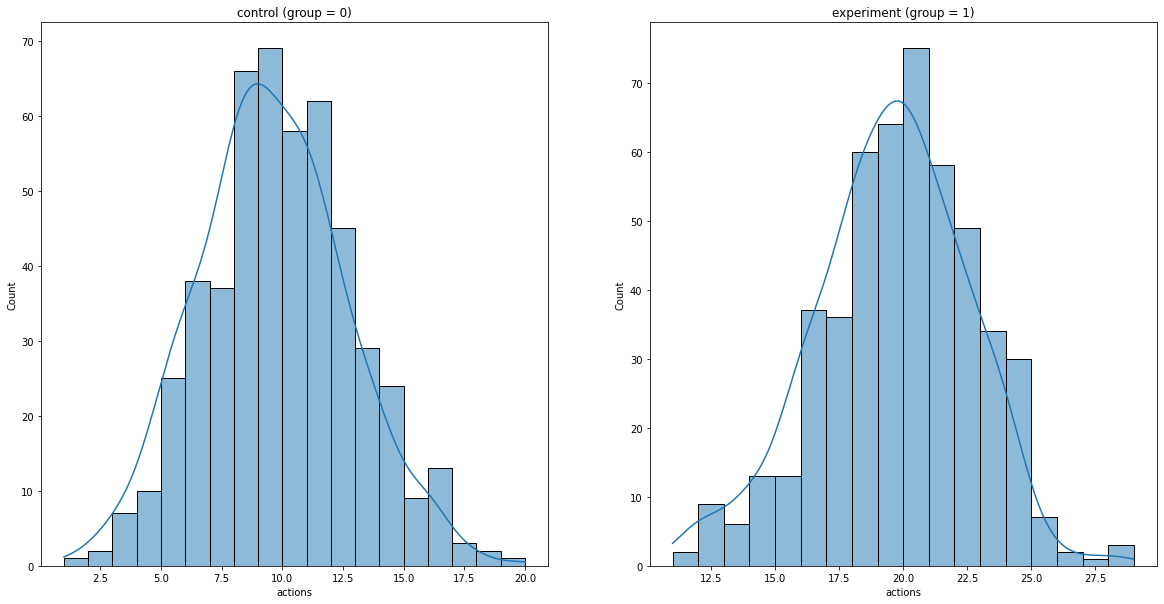

In [29]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

sns.histplot(data=aggregate.query('group == 0'), x='actions', kde=True, ax=axs[0])
axs[0].set_title('control (group = 0)')
sns.histplot(data=aggregate.query('group == 1'), x='actions', kde=True, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

*Визуально, в обеих группах распределения кажутся нормальными. Проведем тест на нормальность с помощью библиотек **pingouin** и **scipy**:*

Text(0.5, 1.0, 'experiment (group = 1)')

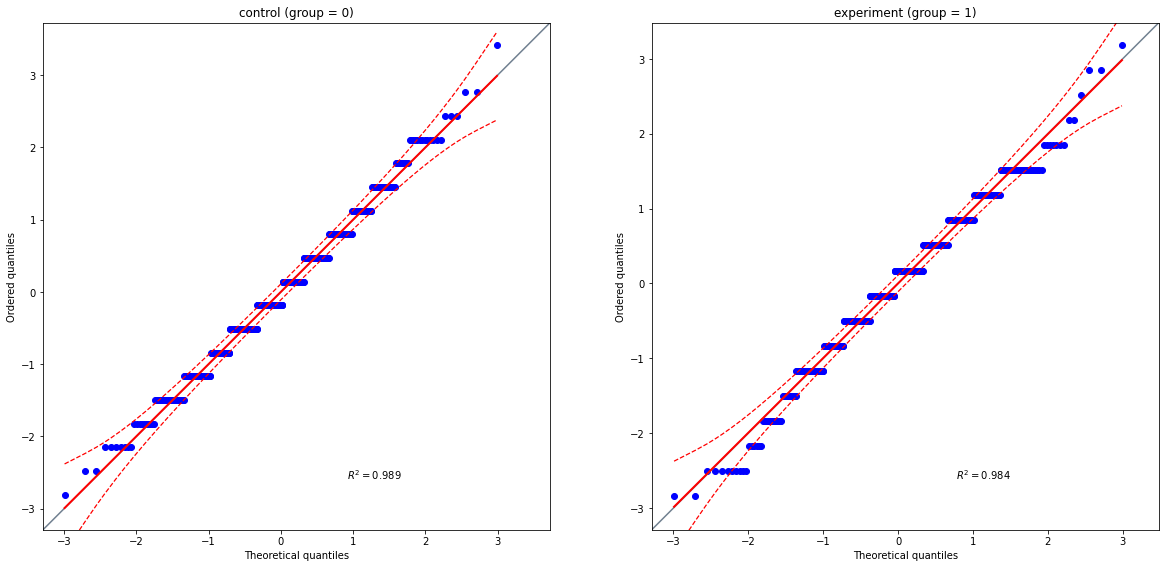

In [30]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(20)
fig.set_figheight(10)

pg.qqplot(x=aggregate.query('group == 0').actions, ax=axs[0])
axs[0].set_title('control (group = 0)')
pg.qqplot(x=aggregate.query('group == 1').actions, ax=axs[1])
axs[1].set_title('experiment (group = 1)')

In [31]:
pg.normality(data=aggregate, dv='actions', group='group')

,W,pval,normal
group,,,
1,0.983930,0.000025,False
0,0.988484,0.000557,False


In [32]:
ss.normaltest(aggregate.query('group == 0').actions)

NormaltestResult(statistic=2.4061675155374465, pvalue=0.300266832562874)

In [33]:
ss.normaltest(aggregate.query('group == 1').actions)

NormaltestResult(statistic=4.262188990750172, pvalue=0.11870729813673231)

<i>Исходя из вышеприведенных результатов можно сделать вывод, что не нужно принимать решения "на глаз". Тесты на нормальность показали, что наши распределения не являются нормальными.

Мы хотим понять, есть ли статистически значимые различия между двумя группами. Будем сравнивать средние значения количества действий.  

Нормальность данных критична только для очень маленьких выборок (примерный ориентир – меньше 30). У нас выборки по 500 записей в каждой, поэтому т-тест будет работать корректно. Тест должен быть параметрическим, т.к. все параметры выборки нам известны.

Плюс мы знаем, что стандартные отклонения наших выборок примерно равны. Поэтому для сравнения средних значений между двумя группами будем использовать <u>т-критерий Стьюдента</u> для наших несвязанных выборок, где:</i>
* <b><font color='red'> $H_0$ (нулевая гипотеза) говорит, о том что средние значения не отличаются;</font></b>

* <b><font color='green'> $H_1$ (альтернативная гипотеза) говорит, о том что средние значения в выборках отличаются.</font></b>

Если рассчитанное p-value будет меньше 0.05, можно будет отвергнуть нулевую гипотезу.

* Произведем расчеты т-теста разными библиотеками:  

In [34]:
pg.ttest(aggregate.query('group == 0').actions, 
         aggregate.query('group == 1').actions,
        correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-51.853838,998,two-sided,1.894288e-285,"[-10.29, -9.54]",3.279531,9.524e+280,1.0


In [35]:
ss.ttest_ind(aggregate.query('group == 0').actions, 
         aggregate.query('group == 1').actions,
            equal_var=True)

Ttest_indResult(statistic=-51.85383774946492, pvalue=1.8942877064043142e-285)

**Мы получили в качестве p-value очень маленькое число - со степенью "-(минус) 285". Это говорит нам, что мы можем отвергнуть нулевую гипотезу и сделать вывод, что <font color='green'>средние между двумя группами статистически различаются.</font>**

**Отрицательное значение переменной т-статистики говорит нам о том, что среднее количество действий в экспериментальной группе выше, чем в контрольной. То есть мы статистически подтвердили полученные выше данные.**



# Аналитическое заключение проведенного анализа данных

<i>Сравнив контрольную и экспериментальную (тестовую) группы по 2 метрикам: доли мэтчей и количеству действий (лайков/дизлайков) можно сделать следующий вывод.</i>

* Эксперимент показал, что доля мэтчей с новым алгоритмом увеличилась. Более того, у нас увеличилось количество действий пользователей в нашем приложении, они стали больше лайкать и дизлайкать. Поэтому новый алгоритм действительно улучшил наш сервис. 

<b>Резюме: <p><font color='green'>> Предлагаем включить новый алгоритм поиска подходящих анкет для всех пользователей нашего приложения.</font></b></p>